In [ ]:
from sklearn.metrics import calinski_harabasz_score
def get_CH_score(df, clusters):
    labels = [clusters[col] for col in df.columns]
    X = df.T.values # transposes data so that features are columns instead of rows
    return calinski_harabasz_score(X, labels)

In [1]:
from data_pipeline.retrieval import DataBank, download_adj_close

In [2]:
data_bank = DataBank()

In [3]:
sec_to_tick_map = data_bank.sector_to_ticker_map()

In [6]:
start = '2023-11-14'
end = '2023-11-27'

In [13]:
sector_dfs = {
    sector : download_adj_close(tickers, start, end, save_data=False) for sector, tickers in sec_to_tick_map.items()
}

[*********************100%%**********************]  77 of 77 completed
[*********************100%%**********************]  64 of 64 completed
[*********************100%%**********************]  64 of 64 completed
[*********************100%%**********************]  38 of 38 completed


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-11-14 00:00:00 -> 2023-11-27)')



[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  72 of 72 completed


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  53 of 53 completed
[*********************100%%**********************]  29 of 29 completed
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  23 of 23 completed


In [24]:
from data_pipeline.processing import ClusterInput

In [138]:
combined_df = pd.concat(list(sector_dfs.values()), axis = 1)

combined_input = ClusterInput(combined_df).df

In [129]:
combined_labels = [sector for sector in sector_dfs.keys() for _ in range(len(sector_dfs[sector].columns))]
len(combined_labels)

501

In [16]:
sectors = list(sec_to_tick_map.keys())

In [68]:
cluster_inputs = [
    ClusterInput(sector_dfs[sector]).df for sector in sectors
]

In [69]:
from sklearn.cluster import KMeans

In [197]:
kmeans = KMeans(init = 'k-means++')

In [198]:
new_clusters = {
    i : None for i in range(len(cluster_inputs))
}

for i, cluster in enumerate(cluster_inputs):
    new_clusters[i] = kmeans.fit(cluster).labels_

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [199]:
new_labels = [f'{sector}_{subcluster}' for (i, sector) in enumerate(sectors) for subcluster in new_clusters[i]]

In [193]:
from data_pipeline.processing import correlation_histogram as corr_hist

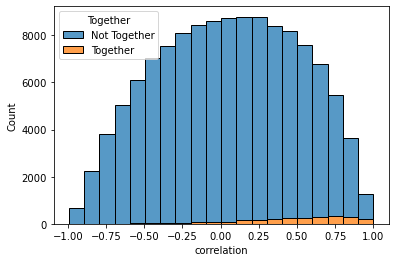

In [200]:
corr_hist(combined_df.pct_change().dropna(), bins = 20, clusters = {ticker : label for (ticker, label) in zip(combined_df.columns, new_labels)})

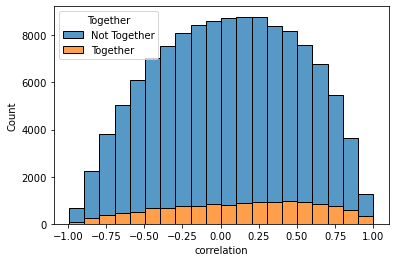

In [132]:
corr_hist(combined_df.pct_change().dropna(), bins = 20, clusters = {ticker : label for (ticker, label) in zip(combined_df.columns, combined_labels)})

In [133]:
from sklearn.metrics import davies_bouldin_score as db_score
from sklearn.metrics import calinski_harabasz_score as ch_score

In [201]:
print(f"""
DB Score for old labels: {db_score(combined_input, combined_labels)}. 
DB Score for new labels: {db_score(combined_input, new_labels)}.
""")


DB Score for old labels: 6.367639758449277. 
DB Score for new labels: 1.7986939860034683.



In [203]:
print(f"""
CH Score for old labels: {ch_score(combined_input, combined_labels)} 
CH Score for new labels: {ch_score(combined_input, new_labels)}
""")


CH Score for old labels: 6.063544656014349 
CH Score for new labels: 13.901430661342529



In [142]:
from collections import Counter

new_counts = Counter(new_labels)

In [144]:
import matplotlib.pyplot as plt

In [217]:
combined_input.iloc[:, 0 : -2]

Date,2023-11-15 00:00:00,2023-11-16 00:00:00,2023-11-17 00:00:00,2023-11-20 00:00:00,2023-11-21 00:00:00
AAL,0.013878,-0.018519,0.008203,0.008950,-0.021774
ADP,0.000174,-0.002387,-0.002262,0.010114,-0.002158
ALK,0.025492,-0.021886,0.015470,0.014962,-0.017422
ALLE,0.006986,-0.006750,0.003775,-0.005736,-0.014942
AME,-0.010534,0.005683,0.010976,-0.005461,0.003811
...,...,...,...,...,...
SLB,-0.012327,-0.029247,0.014201,-0.002081,-0.000379
TRGP,-0.001851,-0.028051,0.025880,0.009998,0.007827
VLO,0.004917,-0.029917,0.017963,0.004996,-0.012507
WMB,0.002550,-0.017807,0.019568,0.005080,0.009548


In [216]:
combined_input.iloc[:, -2 : ]

Date,2023-11-22 00:00:00,2023-11-24 00:00:00
AAL,0.014839,0.000000
ADP,-0.000260,-0.002120
ALK,0.007365,0.007311
ALLE,0.004896,0.003535
AME,0.001609,0.003405
...,...,...
SLB,-0.003794,0.001523
TRGP,-0.003883,0.007108
VLO,0.017780,-0.003191
WMB,0.007789,0.002484


In [218]:
kmeans_alt = KMeans(11)

combined_labels_alt = kmeans_alt.fit(combined_input.iloc[:, 0 : -2]).labels_

c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\elmeh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [220]:
db_score(combined_input.iloc[:, -2 : ], combined_labels_alt), db_score(combined_input.iloc[:, -2 : ], combined_labels)

(11.71851054222678, 14.501231893225729)

In [164]:
combined_labels_alt

array([39, 13, 39, 56, 60, 60, 31, 22,  2,  8, 20, 81, 40, 40, 47,  2,  5,
       10, 52, 73, 68, 74, 60, 40,  8, 40,  7, 13, 62, 62, 47, 47, 31, 85,
       30, 40, 31, 31, 16, 73, 60, 47, 30, 30, 34,  4, 24, 74, 30,  0,  1,
       31, 66, 10, 47, 74, 56,  7, 47, 46, 36, 36, 59, 74, 84,  1, 60, 10,
       10,  5, 86, 20,  6, 13, 60, 13, 25, 21, 31,  5, 22, 42, 86, 30, 24,
       13, 69, 79, 36, 63, 30, 13, 79, 65, 29, 40,  7, 12, 68, 18, 36, 24,
       60,  4, 68, 59, 25, 58,  5, 23, 39, 73, 38,  5, 31, 63, 36, 12, 58,
       47, 44, 61, 73, 18, 31, 73, 73, 13, 79, 22,  5, 12,  2, 30, 45, 34,
       57, 13, 12, 24,  5, 43, 24, 36, 68, 15, 40, 35, 87, 60, 42, 31, 66,
       63, 53, 47, 77,  0, 75, 44,  1,  2, 80,  1, 38, 20, 49, 64, 24, 70,
       47, 36, 33, 86, 43, 43, 10, 39, 43, 31,  4, 47, 49, 51, 44, 39,  8,
       27,  1, 56, 10, 31, 81, 36, 43, 10, 40,  7, 10, 10, 68, 13, 36,  4,
        0,  7,  2, 40, 61, 25, 61, 33, 46, 49, 55, 17, 25, 30, 46, 74, 30,
       30, 30, 30, 33,  0

In [172]:
from tslearn.clustering import TimeSeriesKMeans

In [188]:
tskmeans = TimeSeriesKMeans(n_clusters = 11, init = 'k-means++', metric = "softdtw")

combined_labels_ts = tskmeans.fit(combined_input).labels_

In [189]:
combined_labels_ts

array([9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9,
       9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 0, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9,
       9, 9, 3, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 3, 9, 3, 9, 9, 3, 9, 3, 9, 9, 9,
       9, 0, 9, 9, 9, 3, 3, 9, 9, 3, 3, 3, 9, 3, 9, 9, 3, 9, 0, 9, 3, 9,
       9, 3, 3, 9, 9, 0, 0, 3, 9, 9, 3, 9, 3, 9, 9, 3, 9, 0, 9, 9, 9, 3,
       9, 9, 0, 9, 3, 9, 3, 3, 9, 9, 3, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 0,
       9, 9, 4, 3, 1, 3, 9, 9, 3, 9, 3, 9, 9, 9, 9, 3, 9, 9, 9, 3, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 6, 3, 9, 0, 0, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 3, 9, 3, 9, 9, 4,
       9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 0, 9, 9, 9, 9, 3, 9, 3, 9, 3, 9,
       9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 3, 9, 3,

In [191]:
db_score(combined_input, combined_labels_ts)

1.5252946650058097